In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
dataset_path = '/content/drive/MyDrive/AI_project/Caption_Generator_for_Images/Images'
caption_file = '/content/drive/MyDrive/AI_project/Caption_Generator_for_Images/Flickr_TextData/Flickr8k.token.txt'


In [99]:
def load_captions(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    captions = {}
    for line in lines:
        tokens = line.strip().split('\t')
        image_id = tokens[0].split('#')[0]
        caption = tokens[1].lower()
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(caption)
    return captions

captions_dict = load_captions(caption_file)

In [100]:
import string
def clean_captions(captions):
    table = str.maketrans('', '', string.punctuation)
    for key, cap_list in captions.items():
        cleaned = []
        for caption in cap_list:
            caption = caption.translate(table).lower().strip()
            caption = ' '.join([word for word in caption.split() if word.isalpha()])
            cleaned.append('startseq ' + caption + ' endseq')
        captions[key] = cleaned
    return captions

cleaned_captions = clean_captions(captions_dict)


In [101]:
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from tqdm import tqdm
import numpy as np
import os
import pickle

def extract_features_limited(directory, save_path='features_900.pkl', limit=50):
    base_model = VGG16(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

    features = {}
    image_list = [img for img in os.listdir(directory) if img.lower().endswith('.jpg')]
    image_list = image_list[:limit]

    for img_name in tqdm(image_list):
        try:
            img_path = os.path.join(directory, img_name)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            features[img_name] = feature
        except:
            continue

    with open(save_path, 'wb') as f:
        pickle.dump(features, f)
    return features

features = extract_features_limited(dataset_path)


100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


In [102]:
captions = load_captions(caption_file)

filtered_captions = {}
for key in features.keys():
    if key in captions:
        filtered_captions[key] = captions[key]


In [103]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

for key, caption_list in filtered_captions.items():
    cleaned_list = []
    for caption in caption_list:
        cleaned = clean_text(caption)
        cleaned_list.append(f'startseq {cleaned} endseq')
    filtered_captions[key] = cleaned_list


In [104]:
from tensorflow.keras.preprocessing.text import Tokenizer

all_captions = []
for key in filtered_captions:
    all_captions.extend(filtered_captions[key])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in all_captions)


In [105]:
from tensorflow.keras.utils import to_categorical, pad_sequences
import tensorflow as tf

def data_generator(captions, features, tokenizer, max_length, vocab_size):
    for key, caption_list in captions.items():
        feature = features[key][0]
        for caption in caption_list:
            seq = tokenizer.texts_to_sequences([caption])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                yield (feature, in_seq), out_seq

output_signature = (
    (
        tf.TensorSpec(shape=(4096,), dtype=tf.float32),
        tf.TensorSpec(shape=(max_length,), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(vocab_size,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(filtered_captions, features, tokenizer, max_length, vocab_size),
    output_signature=output_signature
).shuffle(1000).batch(64).prefetch(tf.data.AUTOTUNE)


In [106]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 27)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_36      │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 27, 256)   │    134,656 │ input_layer_37[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 4096)      │          0 │ input_layer_36[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 27, 256)   │          0 │ embedding_6[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_6         │ (None, 27)        │          0 │ input_layer_37[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │  1,048,832 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 256)       │    525,312 │ dropout_13[0][0], │
│                     │                   │            │ not_equal_6[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 256)       │          0 │ dense_18[0][0],   │
│                     │                   │            │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 256)       │     65,792 │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 526)       │    135,182 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,909,774 (7.29 MB)

 Trainable params: 1,909,774 (7.29 MB)

 Non-trainable params: 0 (0.00 B)

In [107]:
model.fit(dataset, epochs=10, verbose=1)


Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - loss: 5.5383
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 4.4236
Epoch 3/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - loss: 3.9459
Epoch 4/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 3.6052
Epoch 5/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - loss: 3.2724
Epoch 6/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 3.0228
Epoch 7/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 19s 216ms/step - loss: 2.6981
Epoch 8/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 2.4792
Epoch 9/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 246ms/step - loss: 2.2768
Epoch 10/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - loss: 2.1087


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [113]:
def generate_caption(model, tokenizer, photo, max_length, beam_index=3):
    start = [tokenizer.word_index['startseq']]
    sequences = [[start, 0.0]]  # (sequence_so_far, current_score)

    while len(sequences[0][0]) < max_length:
        all_candidates = []
        for seq, score in sequences:
            padded_seq = pad_sequences([seq], maxlen=max_length)
            yhat = model.predict([photo, padded_seq], verbose=0)
            top_candidates = np.argsort(yhat[0])[-beam_index:]

            for word_index in top_candidates:
                word = tokenizer.index_word.get(word_index, '')
                if word == '':
                    continue
                new_seq = seq + [word_index]
                new_score = score + np.log(yhat[0][word_index] + 1e-10)
                all_candidates.append([new_seq, new_score])

        sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_index]

    best_seq = sequences[0][0]
    final_caption = [tokenizer.index_word[i] for i in best_seq if i not in [tokenizer.word_index['startseq'], tokenizer.word_index.get('endseq', -1)]]
    return ' '.join(final_caption)


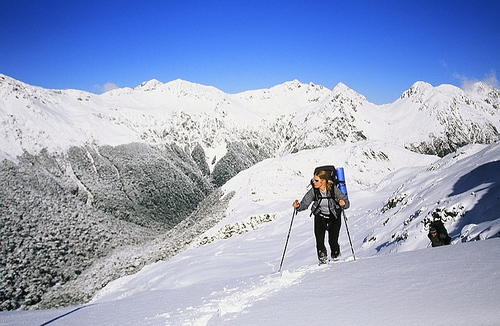


🖼️ Predicted Caption: a hiker is through a snowy snowy mountain


In [112]:
test_image_caption(list(features.keys())[0])
